In [31]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from time import time
from inspyred import ec, benchmarks
from copy import deepcopy
from typing import List, Dict
from collections import Counter

In [ ]:
class ACOWorkoutRoutine:
    def __init__(self, userLevel, equipment, requestMuscles, time, userID, exercises):
        # Initial parameters (same as GA)
        self.userLevel = userLevel.lower()
        self.time = time  # hours
        self.exercises = exercises  # List of exercises
        
        # Assign an index to each exercise based on its position in the list
        for idx, exercise in enumerate(self.exercises):
            exercise['Index'] = idx  # Add 'Index' to each exercise

        self.length = time * 6  # max 6 exercises per hour
        self.equipment = equipment
        self.requestMuscles = requestMuscles
        self.userID = userID
        
        # ACO parameters
        self.num_ants = 50
        self.evaporation = 0.5
        self.alpha = 1  # Pheromone weight
        self.beta = 2   # Heuristic weight
        self.max_iterations = 5
        self.pheromone = None
        
        # Difficulty mapping (same as GA)
        self.difficulty_map = {
            "beginner": 0, "novice": 1, "intermediate": 2,
            "advanced": 3, "expert": 4, "master": 5
        }

        # History
        self.pheromone_history = []
        self.trails_history = []
        self.best_fitness_history = []
    
    def initialize_pheromone(self):
        """Initialize the pheromone matrix with small values"""
        num_exercises = len(self.exercises)
        self.pheromone = np.ones((num_exercises, num_exercises)) * 0.1
    
    def evaluate(self, candidate):
        """Evaluation function (same as GA)"""
        routine = self.get_exercises(candidate)
        n = len(routine)

        y_penalties = self.repetition_penalties(candidate)
        y_factor = sum(y_penalties) / n
        muscles_factor = self.trained_muscles(routine)
        difficulty_factor = self.difficulty_score(routine)
        if not self.equipment == "Gym":
            equipment_factor = self.used_equipment(routine)
        else:
            equipment_factor = 1  # si es gym, no penaliza por equipo

        
        value = 100 * y_factor * muscles_factor * difficulty_factor * equipment_factor
        
        if value < 100:
            bonus = self.calculate_bonus(routine)
            value = min(value + bonus, 100)
            
        return value
    
    def heuristic(self, prev_exercise, next_exercise):
        """Heuristic function that estimates the goodness of choosing next_exercise after prev_exercise"""
        # Penalty for close repetition
        repetition_penalty = 0.95 if prev_exercise == next_exercise else 1.0
        
        # Muscle group diversity
        muscle_diversity = 1.0
        if prev_exercise['TargetMuscleGroup'] != next_exercise['TargetMuscleGroup']:
            muscle_diversity = 1.1
            
        # Combine factors
        return repetition_penalty * muscle_diversity
    
    def select_next_exercise(self, current_exercise, remaining_exercises):
        """Select the next exercise based on pheromone and heuristic"""
        probabilities = []
        total = 0.0
        
        for ex in remaining_exercises:
            # Use exercise indices instead of names
            current_idx = current_exercise['Index']
            next_idx = ex['Index']
            
            pheromone = self.pheromone[current_idx][next_idx]
            heuristic = self.heuristic(current_exercise, ex)
            
            prob = (pheromone * self.alpha) * (heuristic * self.beta)
            probabilities.append((ex['Index'], prob))
            total += prob
        
        # Normalize probabilities
        if total > 0:
            probabilities = [(idx, prob/total) for idx, prob in probabilities]
            probabilities.sort(key=lambda x: x[1], reverse=True)
            
            # Roulette selection
            r = random.random()
            cumulative = 0.0
            for idx, prob in probabilities:
                cumulative += prob
                if r <= cumulative:
                    return idx
                    
        # If all probabilities are 0, select randomly
        return random.choice([ex['Index'] for ex in remaining_exercises])
    
    def construct_solution(self):
        """Construct a solution (routine) with an ant"""
        routine = []
        
        # Select a random initial exercise (by index)
        current = random.choice(self.exercises)
        routine.append(current['Index'])
        
        while len(routine) < self.length:
            next_idx = self.select_next_exercise(current, self.exercises)
            next_ex = next((ex for ex in self.exercises if ex['Index'] == next_idx), None)
            
            if next_ex is None:
                break
                
            routine.append(next_idx)
            current = next_ex
            
        return routine
    
    def update_pheromone(self, solutions):
        """Update the pheromone matrix"""
        # Evaporation
        self.pheromone *= (1 - self.evaporation)
        
        # Deposit pheromone for the best solutions
        for solution, fitness in solutions:
            for i in range(len(solution)-1):
                from_idx = solution[i]
                to_idx = solution[i+1]
                self.pheromone[from_idx][to_idx] += fitness / 100  # Normalized
        
        # History
        self.pheromone_history.append(self.pheromone.copy())
    
    def run(self):
        """Run the ACO algorithm"""
        self.initialize_pheromone()
        best_solution = None
        best_fitness = 0
        
        for iteration in range(self.max_iterations):
            solutions = []
            
            # Build solutions with all ants
            for _ in range(self.num_ants):
                solution = self.construct_solution()
                fitness = self.evaluate(solution)
                solutions.append((solution, fitness))
                
                if fitness > best_fitness:
                    best_fitness = fitness
                    best_solution = solution
            
            # History
            self.trails_history.append(solutions)
            self.best_fitness_history.append(best_fitness)

            # Update pheromone
            self.update_pheromone(solutions)
            
            print(f"Iteration {iteration}: Best fitness = {best_fitness}")
        
        return best_solution, best_fitness
    
    # Helper methods
    def get_exercises(self, candidate):
        return [self.exercises[i] for i in candidate]
    
    def repetition_penalties(self, candidate):
        penalties = [1] * len(candidate)
        for i, idx in enumerate(candidate):
            for j in range(i):
                if candidate[j] == idx:
                    dist = i - j
                    if dist <= 2:
                        penalties[i] = 0.95
                    elif dist <= 8:
                        penalties[i] = 0.99
                    else:
                        penalties[i] = 1
                    break
        return penalties
    
    def difficulty_score(self, routine):
        user_level = self.difficulty_map.get(self.userLevel, 0)
        scores = []
        for ex in routine:
            ex_level = self.difficulty_map.get(ex['DifficultyLevel'].strip().lower(), 0)
            diff = ex_level - user_level
            if diff > 0:
                score = max(0, 1 - 0.2 * diff)
            else:
                score = max(0, 1 - 0.1 * abs(diff))
            scores.append(score)
        return sum(scores) / len(scores)
    
    def used_equipment(self, routine):
        used = set()
        for ex in routine:
            if ex['PrimaryEquipment']:
                used.add(ex['PrimaryEquipment'])
            if ex['SecondaryEquipment']:
                used.add(ex['SecondaryEquipment'])
        if not self.equipment:
            return 1
        return min(0.1 * (len(used) / len(self.equipment)) + 0.9, 1)
    
    def trained_muscles(self, routine):
        target_muscles = [ex['TargetMuscleGroup'].strip().lower()
                        for ex in routine if ex and ex.get('TargetMuscleGroup')]
        muscle_counts = Counter(target_muscles)
        requested = [m.strip().lower() for m in self.requestMuscles]

        if not requested:
            return 1

        total_ex = len(routine)
        valid_ex = sum(1 for m in target_muscles if m in requested)
        required_ratio = 0.75
        if total_ex == 0 or valid_ex / total_ex < required_ratio:
            return 0

        covered = sum(1 for m in requested if muscle_counts[m] > 0)
        coverage = covered / len(requested)

        total_requested_ej = sum(muscle_counts[m] for m in requested)
        if total_requested_ej == 0:
            return 0
        ideal = total_requested_ej / len(requested)
        balance = 1 - sum(abs(muscle_counts[m] - ideal) for m in requested) / total_requested_ej

        extra = [m for m in muscle_counts if m not in requested]
        penalty = len(extra) / len(muscle_counts) if muscle_counts else 1

        factor = coverage * balance * (1 - penalty)
        return max(min(factor, 1), 0)

    def calculate_bonus(self, routine):
        extra_bonus = 0
        seen_regions = set()
        for ex in routine:
            muscle = ex['TargetMuscleGroup']
            region = ex['BodyRegion']
            if muscle not in self.requestMuscles:
                if region in seen_regions:
                    extra_bonus += 0.1
                else:
                    extra_bonus += 0.05
                seen_regions.add(region)
        return extra_bonus

In [ ]:
# getting the exercises form the CSV file
import pandas as pd

df = pd.read_csv('../assets/exercises.csv')

#Inicializar Problema
userLevel = "novice"
equipment = ["Barbell","Sliders","Dumbbell","Miniband"]
requestMuscles = ["Glutes", "Quadriceps", "Forearms", "Triceps","Chest"]
duration = 6
userID = 12345
exercises = df.to_dict(orient='records')
problem = ACOWorkoutRoutine(userLevel, equipment, requestMuscles, duration, userID, exercises)
best = problem.run()[0]

Iteration 0: Best fitness = 14.784782608695652
Iteration 1: Best fitness = 21.550000000000004
Iteration 2: Best fitness = 22.837830687830685
Iteration 3: Best fitness = 22.837830687830685
Iteration 4: Best fitness = 33.267391304347825


In [72]:
# Print the routine according to the best solution, ordered by TargetMuscleGroup
sorted_routine = sorted(best, key=lambda x: exercises[x]['TargetMuscleGroup'])
for i in sorted_routine:
    print(exercises[i]['TargetMuscleGroup'] + " - " + exercises[i]['DifficultyLevel'] + " - " + exercises[i]['BodyRegion'])

Abdominals - Novice - Midsection
Abdominals - Expert - Midsection
Abdominals - Novice - Midsection
Abdominals - Advanced - Midsection
Abdominals - Intermediate - Midsection
Abdominals - Novice - Midsection
Back - Intermediate - Upper Body
Back - Novice - Full Body
Biceps - Advanced - Upper Body
Biceps - Beginner - Upper Body
Biceps - Advanced - Upper Body
Chest - Novice - Upper Body
Chest - Expert - Upper Body
Chest - Expert - Upper Body
Chest - Master - Upper Body
Chest - Beginner - Upper Body
Chest - Novice - Upper Body
Glutes - Novice - Lower Body
Quadriceps - Intermediate - Lower Body
Quadriceps - Novice - Lower Body
Quadriceps - Novice - Lower Body
Quadriceps - Novice - Lower Body
Quadriceps - Novice - Lower Body
Quadriceps - Intermediate - Lower Body
Quadriceps - Intermediate - Full Body
Quadriceps - Intermediate - Lower Body
Shins - Novice - Lower Body
Shoulders - Novice - Upper Body
Shoulders - Novice - Upper Body
Shoulders - Intermediate - Upper Body


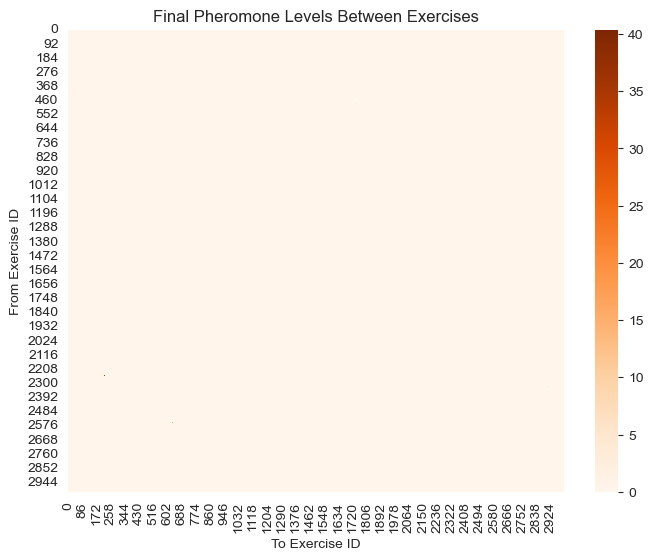

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style('darkgrid')

# Final pheromone matrix
pheromones = np.array(problem.pheromone_history[-1])
plt.figure(figsize=(8, 6))
sns.heatmap(pheromones, cmap='Oranges')
plt.title("Final Pheromone Levels Between Exercises")
plt.xlabel("To Exercise ID")
plt.ylabel("From Exercise ID")
plt.show()

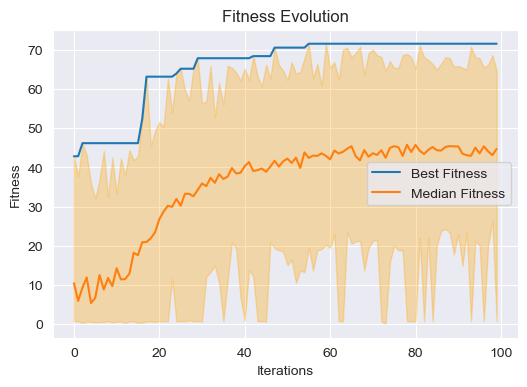

In [50]:
fitness = np.array([[ant[1] for ant in trails] for trails in problem.trails_history])
best_fitness = np.array(problem.best_fitness_history)

fig, axs = plt.subplots(figsize=(6, 4))
axs.set_title('Fitness Evolution')
axs.set_xlabel('Iterations')
axs.set_ylabel('Fitness')

axs.plot(best_fitness, label='Best Fitness')

median = np.median(fitness, axis=1)
min_ = np.min(fitness, axis=1)
max_ = np.max(fitness, axis=1)

axs.plot(median, label='Median Fitness')
axs.fill_between(np.arange(len(median)), min_, max_, alpha=0.3, color='orange')

axs.legend()
plt.show()

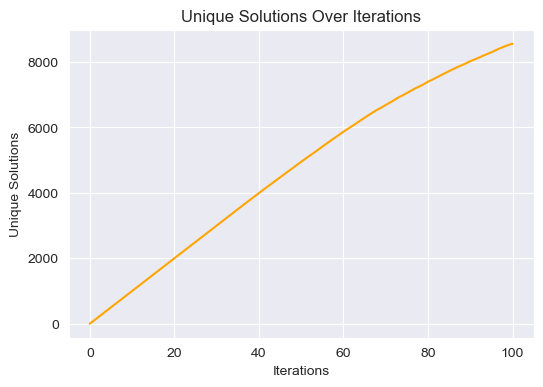

In [51]:
from itertools import accumulate
from typing import List

# Population per iteration
population = np.array([[np.array(ant[0]) for ant in trails] for trails in problem.trails_history])

def stringify_individual(individual: List[int]) -> str:
    return ''.join([str(int(i)) for i in individual])

# Convert and accumulate unique sets
a = np.apply_along_axis(stringify_individual, 2, population)
a = list(accumulate(a, lambda x, y: x.union(set(y)), initial=set()))

fig, axs = plt.subplots(figsize=(6, 4))
axs.plot([len(x) for x in a], color='orange')
axs.set_title('Unique Solutions Over Iterations')
axs.set_xlabel('Iterations')
axs.set_ylabel('Unique Solutions')
plt.show()